In [1]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)
warnings.simplefilter('ignore')
sns.set()

In [2]:
base_dir = Path().resolve()
sys.path.append(str(base_dir / '../'))

from utils.preprocess import *
from utils.model import *
from utils.train import *
from utils.eval import *
from utils.detectron2helper import *

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.
** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



HACKING: overriding COCOeval.summarize = vin_summarize...


In [3]:
from dataclasses import dataclass, field, asdict
import yaml


@dataclass
class Config:
    # Data config
    imgconf_file: str = '../../data/VinBigData/train.csv'
    meta_file: str = '../../data/VinBigData/train_meta.csv'
    test_meta_file: str = '../../data/VinBigData/test_meta.csv'
    imgdir_name: str = "../../data/VinBigData/png[tmp]"
    seed: int = 111
    n_splits: int = 5

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)
            

config = Config()

In [4]:
def load_train_data(filepath: str, meta_filepath: str, img_size: int) -> pd.DataFrame:
    train = pd.read_csv(filepath)
    train.fillna(0, inplace=True)
    train.loc[train["class_id"] == 14, ['x_max', 'y_max']] = 1.0
    
    train_meta = pd.read_csv(meta_filepath)
    
    train = pd.merge(train, train_meta, how='left', on='image_id')
    
    train[f'x_min_{img_size}'] = (img_size / train['dim1'] * train['x_min'])
    train[f'x_max_{img_size}'] = (img_size / train['dim1'] * train['x_max'])
    train[f'y_min_{img_size}'] = (img_size / train['dim0'] * train['y_min'])
    train[f'y_max_{img_size}'] = (img_size / train['dim0'] * train['y_max'])
    
    return train

In [5]:
from ensemble_boxes import *


def change_wbf(dataset_dict: Dict[str, Any], iou_thr: float, skip_box_thr: float, n_cls: int):
    cls_ids = list(range(n_cls))
    
    height, width = dataset_dict['height'], dataset_dict['width']
    
    boxes = list()
    labels = list()
    scores = [1.0] * len(dataset_dict['annotations'])
        
    for obj in dataset_dict['annotations']:
        box = [
            obj['bbox'][0] / width,
            obj['bbox'][1] / height,
            obj['bbox'][2] / width,
            obj['bbox'][3] / height
        ]
        boxes += [box]
        labels += [obj['category_id']]
    
    boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    annots = list()
    for box_, label_ in zip(boxes, labels):
        annots += [{
            'bbox': [
                box_[0] * width,
                box_[1] * height,
                box_[2] * width,
                box_[3] * height
            ],
            'category_id': int(label_),
            'bbox_mode': BoxMode.XYXY_ABS,
        }]
        
    return {
        'file_name': dataset_dict['file_name'],
        'image_id': dataset_dict['image_id'],
        'height': height,
        'width': width,
        'annotations': annots
    }

In [6]:
from typing import List, Tuple

import matplotlib.patches as patches
import numpy as np
from PIL import Image


def add_bboxes_to_image(ax, image: np.ndarray,
                        bboxes: List[Tuple[int, int, int, int]],
                        labels: List[str] = None,
                        label_size: int = 10,
                        line_width: int = 2,
                        border_color=(0, 1, 0, 1)) -> None:
    """
    Add bbox to ax

    :param image: dtype=np.uint8
    :param bbox: [(left, top, right, bottom)]
    :param label: List[str] or None
    :return: ax
    """
    # Display the image
    ax.imshow(image)

    if labels is None:
        labels = [None] * len(bboxes)

    for bbox, label in zip(bboxes, labels):
        # Add bounding box
        x_min, y_min, x_max, y_max = bbox
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=line_width,
                                 edgecolor=border_color,
                                 facecolor='none')
        ax.add_patch(rect)

        # label
        if label:
            bbox_props = dict(boxstyle="square,pad=0",
                              linewidth=line_width, facecolor=border_color,
                              edgecolor=border_color)
            ax.text(x_min, y_min, label,
                    ha="left", va="bottom", rotation=0,
                    size=label_size, bbox=bbox_props)
    return ax


def plot_samples(dataset_dicts):
    train_dataset = VinBigDataset(dataset_dicts=dataset_dicts, transform=Transform({}, train=True))
    fig, axes = plt.subplots(1, 4, figsize=(25, 6))
    for i, ax in enumerate(axes):
        img, target, _ = train_dataset[i]
        img = img.numpy().transpose((1, 2, 0))
        add_bboxes_to_image(ax, np.uint8(img), target['boxes'], target['labels'].numpy())
        ax.axis("off")
    plt.show()

In [7]:
list_remove = [34843, 21125, 647, 18011, 2539, 22373, 12675, 7359, 20642, 5502, 19818, 5832, 28056, 28333, 20758,
               925, 43, 2199, 4610, 21306, 16677, 1768, 17232, 1378, 24949, 30203, 31410, 87, 25318, 92, 31724,
               118, 17687, 12605, 26157, 33875, 7000, 3730, 18776, 13225, 1109, 2161, 33627, 15500, 28633, 28152,
               10114, 10912, 9014,  4427, 25630, 11464, 6419, 22164, 4386, 17557, 15264, 21853, 33142, 32895, 9733,
               33010, 17493, 32128, 28802, 11658, 8841, 29557, 4802, 8591, 778, 9935, 12359, 5210, 7556, 24505, 5664,
               28670, 27820, 19359, 9817, 7800, 32934, 34098, 27931, 16074, 27308, 30645, 31029, 35697, 6199, 27065,
               1771, 14689, 31860, 1975, 29294, 2304, 34018, 23406, 26501, 26011, 2479, 32796, 25836, 3032, 31454,
               32066, 19722, 15997, 6049, 9458, 11005, 23151, 24503, 35411, 18092, 23815, 30742, 33942, 34542, 7655,
               25345, 3750, 17046, 3844, 5958, 4250, 18823, 14898, 22581, 25805, 9651, 33194, 36007, 30160, 24459,
               10838, 16544, 31252, 8053, 28487, 6208, 25244, 8470, 10089, 24813, 14769, 34305, 34047, 23366, 8049,
               13276, 22380, 32797, 32440, 11031, 18304, 33692, 21349, 26333, 34331, 9110, 21092, 34882, 35626, 10203,
               25648, 30754, 29567, 33542, 15146, 26759, 20846, 22493, 33187, 22813, 30219, 14548, 14627, 20494, 28332,
               15930, 31347, 33489, 35005, 34032, 24183, 18643, 18536, 29754, 20380, 29750, 20539, 35791, 27275, 32248]
image_remove = ['9c83d9f88170cd38f7bca54fe27dc48a', 'ac2a615b3861212f9a2ada6acd077fd9',
                'f9f7feefb4bac748ff7ad313e4a78906', 'f89143595274fa6016f6eec550442af9',
                '6c08a98e48ba72aee1b7b62e1f28e6da', 'e7a58f5647d24fc877f9cb3d051792e2',
                '8f98e3e6e86e573a6bd32403086b3707', '43d3137e74ebd344636228e786cb91b0',
                '575b98a9f9824d519937a776bd819cc4', 'ca6c1531a83f8ee89916ed934f8d4847',
                '0c6a7e3c733bd4f4d89443ca16615fc6', 'ae5cec1517ab3e82c5374e4c6219a17d',
                '064023f1ff95962a1eee46b9f05f7309', '27c831fee072b232499541b0aca58d9c',
                '0b98b21145a9425bf3eeea4b0de425e7', '7df5c81873c74ecc40610a1ad4eb2943']

In [8]:
classes_nms = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis",
#     "No Finding"
]
classes_dict = {index: class_name  for index, class_name in enumerate(classes_nms)}

False 256 0.1
Load from cache dataset_dicts_cache_png256_debug0.pkl


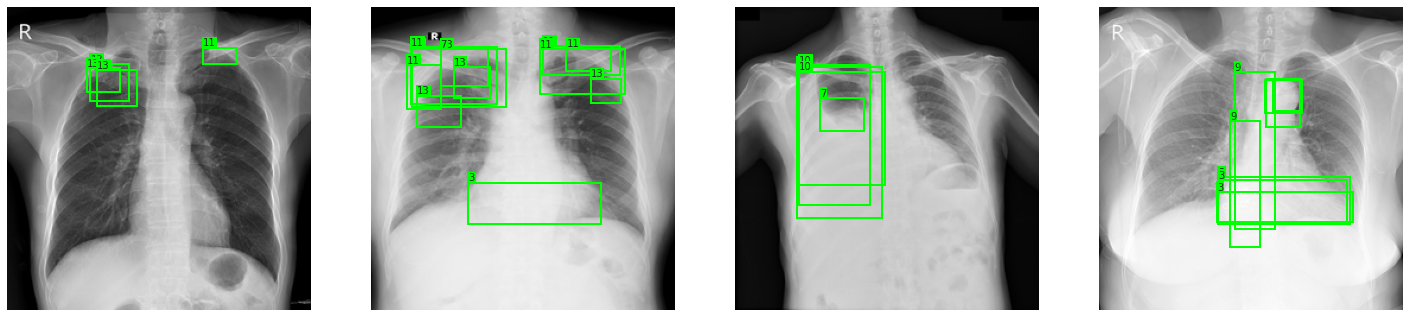

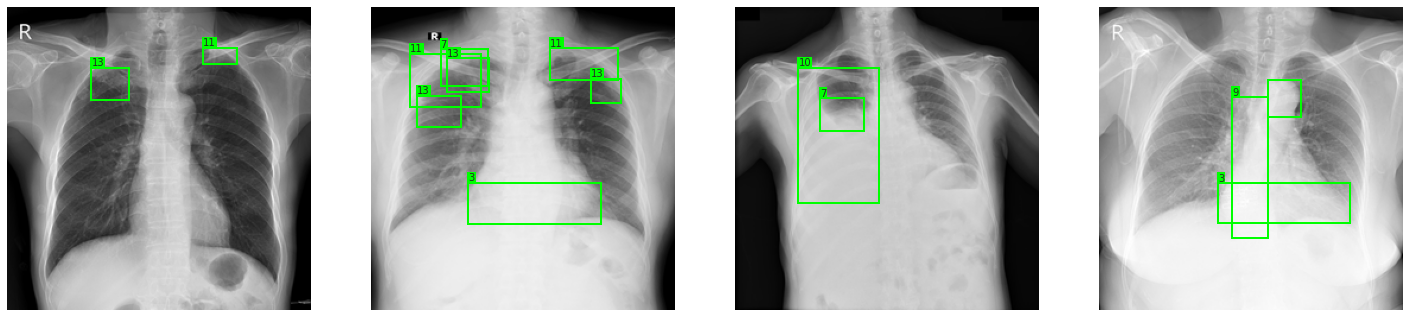

False 512 0.1
Load from cache dataset_dicts_cache_png512_debug0.pkl


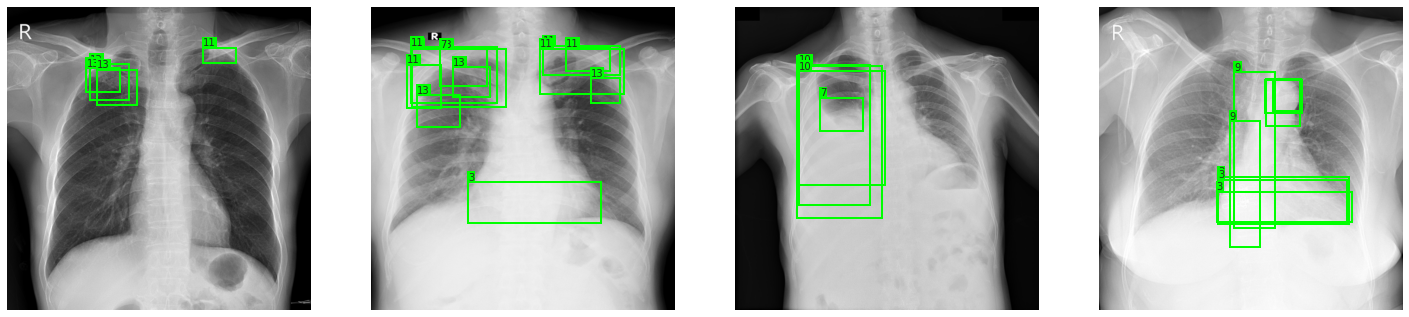

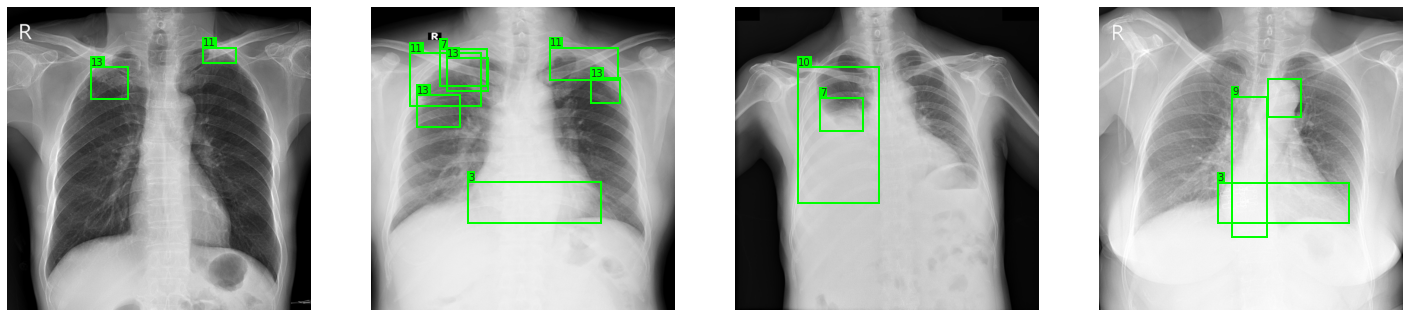

False 1024 0.1


KeyboardInterrupt: 

In [10]:
for is_rm in [False, True]:
    rm = '_rm' if is_rm else ''

    for img_size in [256, 512, 1024]:
        for iou_thr in [0.1, 0.5]:
            print(is_rm, img_size, iou_thr)
            train = load_train_data(filepath=str(base_dir / config.imgconf_file), meta_filepath=str(base_dir / config.meta_file), img_size=img_size)
            train = train.query('class_id != 14')
            
            if is_rm:
                train = train[~train.index.isin(list_remove)]
                train = train.query(f'image_id not in {image_remove}')
            train = train.reset_index(drop=True)
            
            dataset_dicts = get_vinbigdata_dicts(
                imgdir=base_dir / config.imgdir_name.replace('[tmp]', str(img_size)),
                meta_filepath=base_dir / config.meta_file,
                train_df=train,
                train_data_type=f'png{img_size}{rm}',
                debug=False,
            )

            dataset_dicts = [dd for dd in dataset_dicts if len(dd['annotations']) > 0]
            plot_samples(dataset_dicts)

            # label cleaning
            dataset_dicts = [change_wbf(dd, iou_thr=iou_thr, skip_box_thr=0., n_cls=len(classes_nms)) for dd in dataset_dicts]
            plot_samples(dataset_dicts)
            
            break
            
            records = {'image_id': list(), 'class_name': list(), 'class_id': list(), 'x_min': list(), 'y_min': list(), 'x_max': list(), 'y_max': list()}

            for dd in dataset_dicts:
                for annot in dd['annotations']:
                    box = annot['bbox']

                    records['image_id'] += [dd['image_id']]
                    records['class_name'] += [classes_nms[annot['category_id']]]
                    records['class_id'] += [annot['category_id']]
                    records['x_min'] += [annot['bbox'][0]]
                    records['y_min'] += [annot['bbox'][1]]
                    records['x_max'] += [annot['bbox'][2]]
                    records['y_max'] += [annot['bbox'][3]]

            train = pd.DataFrame(records)
            mkf = MultilabelKFoldWrapper(train, n_splits=config.n_splits, seed=config.seed, remove_normal=True)
            pickle.dump(mkf, open(str(base_dir / 'detectron2_results' / f'nms{iou_thr}_mkf_{img_size}{rm}.pkl'), 'wb'))
            pickle.dump(dataset_dicts, open(str(base_dir / 'detectron2_results' / f'nms{iou_thr}_dataset_dicts_{img_size}{rm}.pkl'), 'wb'))
            pickle.dump(train, open(str(base_dir / 'detectron2_results' / f'nms{iou_thr}_train_{img_size}{rm}.pkl'), 'wb'))